## Environment Setup

In [1]:
!pip install transformers
!pip install pytorch-lightning
!pip install python-docx
!pip install text2emotion
!pip install --upgrade text2emotion emoji
!pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184487 sha256=544ee15eb9bfae7010993b80598d696eeec1bd2dc08ac21608025d82459eabb7
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Loading Libraries

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
import torch
import numpy as np
from nltk.tokenize import sent_tokenize
from docx import Document
import nltk
nltk.download('punkt')
import spacy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import re
from collections import defaultdict
import pandas as pd
import text2emotion as te
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Reading Text

- In this part I filter the dataset to only read records from the 'Antony & Cleopatra' by Shakespeare

In [3]:
theater_df = pd.read_csv('Shakespeare_data.csv')
theater_df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [4]:
theater_df['Play'].unique()

array(['Henry IV', 'Henry VI Part 1', 'Henry VI Part 2',
       'Henry VI Part 3', 'Alls well that ends well', 'As you like it',
       'Antony and Cleopatra', 'A Comedy of Errors', 'Coriolanus',
       'Cymbeline', 'Hamlet', 'Henry V', 'Henry VIII', 'King John',
       'Julius Caesar', 'King Lear', 'Loves Labours Lost', 'macbeth',
       'Measure for measure', 'Merchant of Venice',
       'Merry Wives of Windsor', 'A Midsummer nights dream',
       'Much Ado about nothing', 'Othello', 'Pericles', 'Richard II',
       'Richard III', 'Romeo and Juliet', 'Taming of the Shrew',
       'The Tempest', 'Timon of Athens', 'Titus Andronicus',
       'Troilus and Cressida', 'Twelfth Night', 'Two Gentlemen of Verona',
       'A Winters Tale'], dtype=object)

In [5]:
theater_df = theater_df.loc[theater_df['Play'] == 'Antony and Cleopatra']
theater_df[['Act', 'Scene', 'Line']] = theater_df['ActSceneLine'].str.split('.', expand=True)
theater_df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Line
18565,18566,Antony and Cleopatra,52.0,NaN,ROSALIND,ACT I,NaN,NaN,NaN
18566,18567,Antony and Cleopatra,52.0,NaN,ROSALIND,SCENE I. Alexandria. A room in CLEOPATRA's pal...,NaN,NaN,NaN
18567,18568,Antony and Cleopatra,52.0,NaN,ROSALIND,Enter DEMETRIUS and PHILO,NaN,NaN,NaN
18568,18569,Antony and Cleopatra,1.0,1.1.1,PHILO,"Nay, but this dotage of our general's",1,1,1
18569,18570,Antony and Cleopatra,1.0,1.1.2,PHILO,"O'erflows the measure: those his goodly eyes,",1,1,2


In [6]:
condition = theater_df['Player'] == 'ROSALIND'
theater_df = theater_df.loc[~condition].reset_index()
theater_df = theater_df.drop(columns=['index', 'Dataline', 'PlayerLinenumber', 'ActSceneLine'])
theater_df.head()

,Play,Player,PlayerLine,Act,Scene,Line
0,Antony and Cleopatra,PHILO,"Nay, but this dotage of our general's",1,1,1
1,Antony and Cleopatra,PHILO,"O'erflows the measure: those his goodly eyes,",1,1,2
2,Antony and Cleopatra,PHILO,That o'er the files and musters of the war,1,1,3
3,Antony and Cleopatra,PHILO,"Have glow'd like plated Mars, now bend, now turn,",1,1,4
4,Antony and Cleopatra,PHILO,The office and devotion of their view,1,1,5


## Retrieving Characters

- In this part I retrieve the list of characters and then plot the main characters who appear in 25 records or more. Where each record represents a part of the sentence (if not an entire sentence) recited by a character.

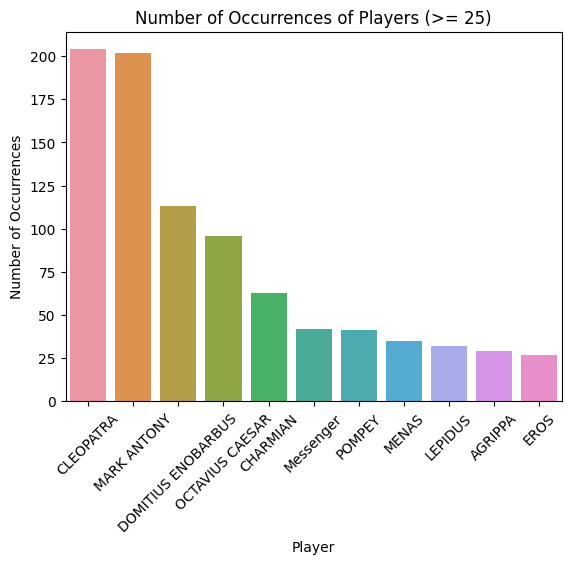

In [7]:
# Create a column to mark the start of each unique player sequence, in order to know if a player is appearing in consecutive records or not.
# If yes, then he is still reciting one of his lines in the scene.
theater_df['StartOfSequence'] = theater_df['Player'] != theater_df['Player'].shift(1)

# Counting the occurrences of unique player sequences
unique_sequence_counts = theater_df.groupby(theater_df['StartOfSequence'].cumsum())['Player'].first().value_counts()

# Filtering for players with occurrences greater than or equal to 25
filtered_counts = unique_sequence_counts[unique_sequence_counts >= 25]
main_characters = filtered_counts.index.tolist()

sns.barplot(x=filtered_counts.index, y=filtered_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Player')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences of Players (>= 25)')
plt.show()

In [8]:
# Filtering the DataFrame and only retrieving the main characters
main_characters_df = theater_df[theater_df['Player'].isin(main_characters)]
main_characters_df = main_characters_df.dropna()
main_characters_df= main_characters_df.reset_index()
main_characters_df= main_characters_df.drop(columns=['index'])
main_characters_df.head()

,Play,Player,PlayerLine,Act,Scene,Line,StartOfSequence
0,Antony and Cleopatra,CLEOPATRA,"If it be love indeed, tell me how much.",1,1,15,True
1,Antony and Cleopatra,MARK ANTONY,There's beggary in the love that can be reckon'd.,1,1,16,True
2,Antony and Cleopatra,CLEOPATRA,I'll set a bourn how far to be beloved.,1,1,17,True
3,Antony and Cleopatra,MARK ANTONY,"Then must thou needs find out new heaven, new ...",1,1,18,True
4,Antony and Cleopatra,MARK ANTONY,Grates me: the sum.,1,1,20,True


## Emotion Detection - Text2Emotion Approach

- Using a non hugging face model and considering it as a simplified approach

In [9]:
emotions = {}
for i in range(len(main_characters_df)):
    player_name = main_characters_df.loc[i, 'Player']
    player_line = main_characters_df.loc[i, 'PlayerLine']
    if player_name in main_characters:
        emotion = te.get_emotion(player_line)
        if player_name not in emotions:
            emotions[player_name] = []
        emotions[player_name].append({'index': i, 'emotion': emotion})

In [10]:
# Creating columns for each main character's emotion types
for character, emotion_entries in emotions.items():
    for entry in emotion_entries:
        index = entry['index']
        emotion = entry['emotion']
        for emotion_type, score in emotion.items():
            emotion_column_name = f'{emotion_type}'
            main_characters_df.at[index, emotion_column_name] = score

In [11]:
main_characters_df.head()

,Play,Player,PlayerLine,Act,Scene,Line,StartOfSequence,Happy,Angry,Surprise,Sad,Fear
0,Antony and Cleopatra,CLEOPATRA,"If it be love indeed, tell me how much.",1,1,15,True,1.0,0.0,0.0,0.0,0.0
1,Antony and Cleopatra,MARK ANTONY,There's beggary in the love that can be reckon'd.,1,1,16,True,1.0,0.0,0.0,0.0,0.0
2,Antony and Cleopatra,CLEOPATRA,I'll set a bourn how far to be beloved.,1,1,17,True,0.0,0.0,0.0,0.0,1.0
3,Antony and Cleopatra,MARK ANTONY,"Then must thou needs find out new heaven, new ...",1,1,18,True,0.0,0.0,1.0,0.0,0.0
4,Antony and Cleopatra,MARK ANTONY,Grates me: the sum.,1,1,20,True,0.0,1.0,0.0,0.0,0.0


In [12]:
emotions = ['Happy', 'Sad', 'Angry', 'Fear', 'Surprise']
#Labeling w/ dominant Emotion
main_characters_df['Emotion'] = main_characters_df[emotions].apply(lambda row: next((e for e in emotions if row[e] == 1.0), 'Neutral'), axis=1)
main_characters_df = main_characters_df.drop(columns=['Happy','Angry','Surprise','Sad','Fear'])
main_characters_df.head()

,Play,Player,PlayerLine,Act,Scene,Line,StartOfSequence,Emotion
0,Antony and Cleopatra,CLEOPATRA,"If it be love indeed, tell me how much.",1,1,15,True,Happy
1,Antony and Cleopatra,MARK ANTONY,There's beggary in the love that can be reckon'd.,1,1,16,True,Happy
2,Antony and Cleopatra,CLEOPATRA,I'll set a bourn how far to be beloved.,1,1,17,True,Fear
3,Antony and Cleopatra,MARK ANTONY,"Then must thou needs find out new heaven, new ...",1,1,18,True,Surprise
4,Antony and Cleopatra,MARK ANTONY,Grates me: the sum.,1,1,20,True,Angry


## Emotion Detection - Hugging Face Model Hub's EmoRoberta

- Using a hugging face model: 'arpanghoshal/EmoRoBERTa', the reason this model was selected is because it portrays a wider spectrum of emotions. This should be appropriate especially when analyzing the emotion of each line in a theatrical play.

In [12]:
emotion_2 = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [13]:
emotions_2 = {}
for i in range(len(main_characters_df)):
    player_name = main_characters_df.loc[i, 'Player']
    player_line = main_characters_df.loc[i, 'PlayerLine']
    if player_name in main_characters:
        emotion = emotion_2(player_line)
        if player_name not in emotions_2:
            emotions_2[player_name] = []
        emotions_2[player_name].append({'index': i, 'emotion': emotion})

In [14]:
# Creating columns for each main character's emotion types
for character, emotion_entries in emotions_2.items():
    for entry in emotion_entries:
        index = entry['index']
        emotion_list = entry['emotion']
        for emotion_type, score in emotion_list[0].items():
            emotion_column_name = f'second_{emotion_type}'
            main_characters_df.at[index, emotion_column_name] = score

In [15]:
main_characters_df.rename(columns={'Emotion': 'First_Type_Emotion', 'second_label': 'Second_Type_Emotion'}, inplace=True)

# Dropping columns and adjusting column values/names
main_characters_df = main_characters_df.drop(columns=['second_score'])
main_characters_df['Second_Type_Emotion'] = main_characters_df['Second_Type_Emotion'].str.title()

main_characters_df = main_characters_df.dropna()

main_characters_df.head()

,Play,Player,PlayerLine,Act,Scene,Line,StartOfSequence,First_Type_Emotion,Second_Type_Emotion
0,Antony and Cleopatra,CLEOPATRA,"If it be love indeed, tell me how much.",1,1,15,True,Happy,Curiosity
1,Antony and Cleopatra,MARK ANTONY,There's beggary in the love that can be reckon'd.,1,1,16,True,Happy,Neutral
2,Antony and Cleopatra,CLEOPATRA,I'll set a bourn how far to be beloved.,1,1,17,True,Fear,Love
3,Antony and Cleopatra,MARK ANTONY,"Then must thou needs find out new heaven, new ...",1,1,18,True,Surprise,Neutral
4,Antony and Cleopatra,MARK ANTONY,Grates me: the sum.,1,1,20,True,Angry,Grief


## Comparing Results Of The Two Models

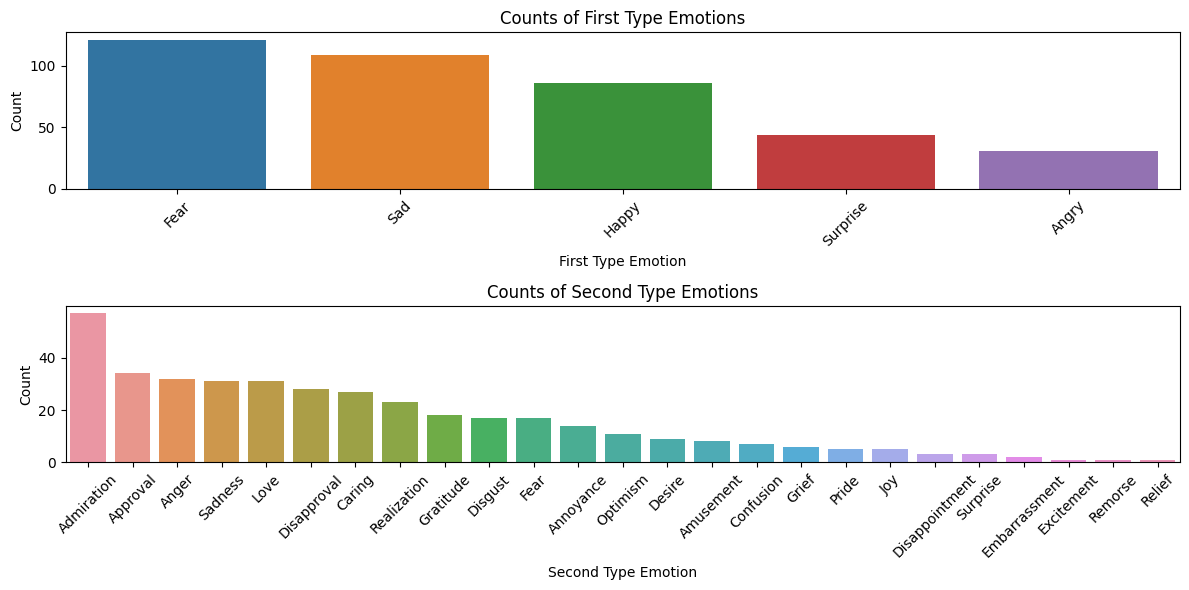

In [29]:
# Filtering out 'Neutral' emotions --> Not useful in our case
filtered_df = main_characters_df[(main_characters_df['First_Type_Emotion'] != 'Neutral') & (main_characters_df['Second_Type_Emotion'] != 'Neutral') & (main_characters_df['Second_Type_Emotion'] != 'Curiosity')]

# Calculating value counts for each column, i.e. model
first_type_counts = filtered_df['First_Type_Emotion'].value_counts()
second_type_counts = filtered_df['Second_Type_Emotion'].value_counts()

# Creating a figure w/ 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plotting the first type emotion
sns.barplot(x=first_type_counts.index, y=first_type_counts.values, ax=axes[0])
axes[0].set_title('Counts of First Type Emotions')
axes[0].set_xlabel('First Type Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the second type emotion
sns.barplot(x=second_type_counts.index, y=second_type_counts.values, ax=axes[1])
axes[1].set_title('Counts of Second Type Emotions')
axes[1].set_xlabel('Second Type Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Visualizing The Different Emotions Expressed By Each Main Character

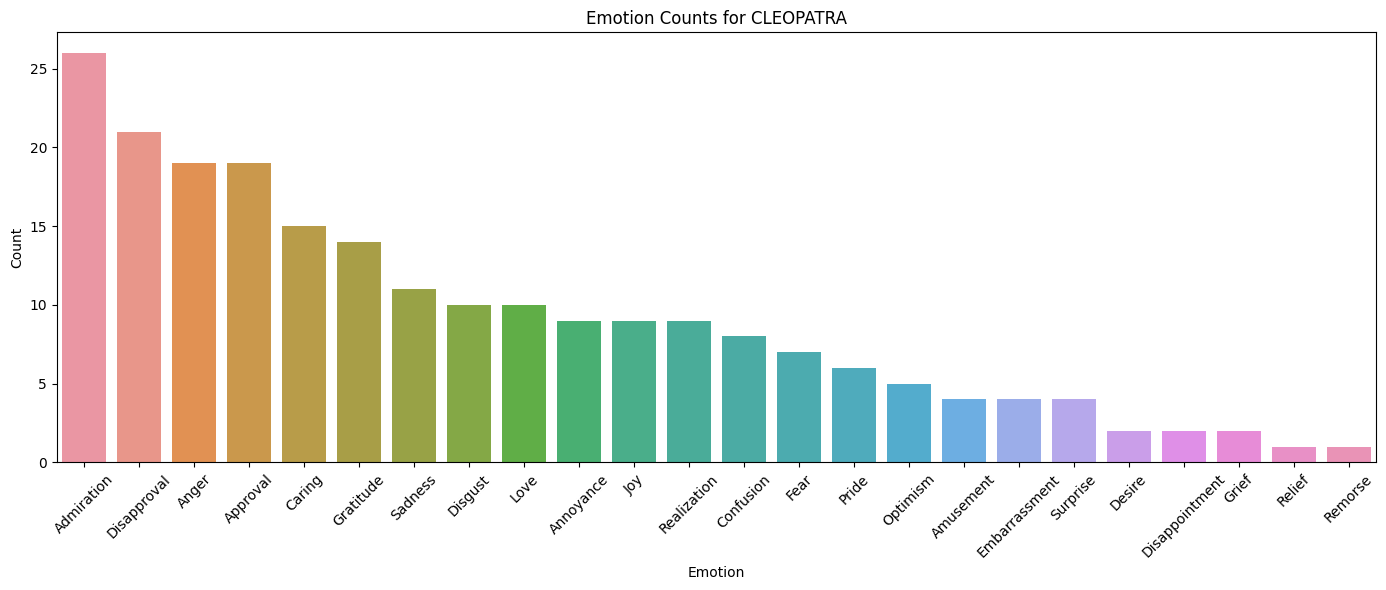

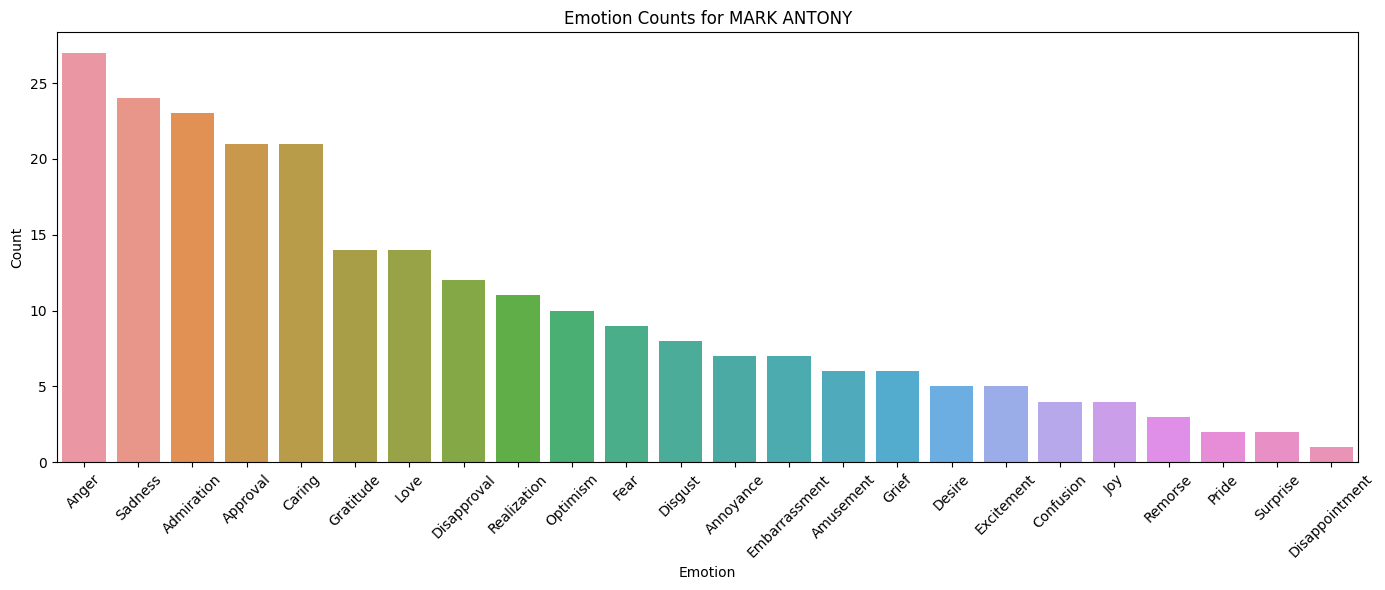

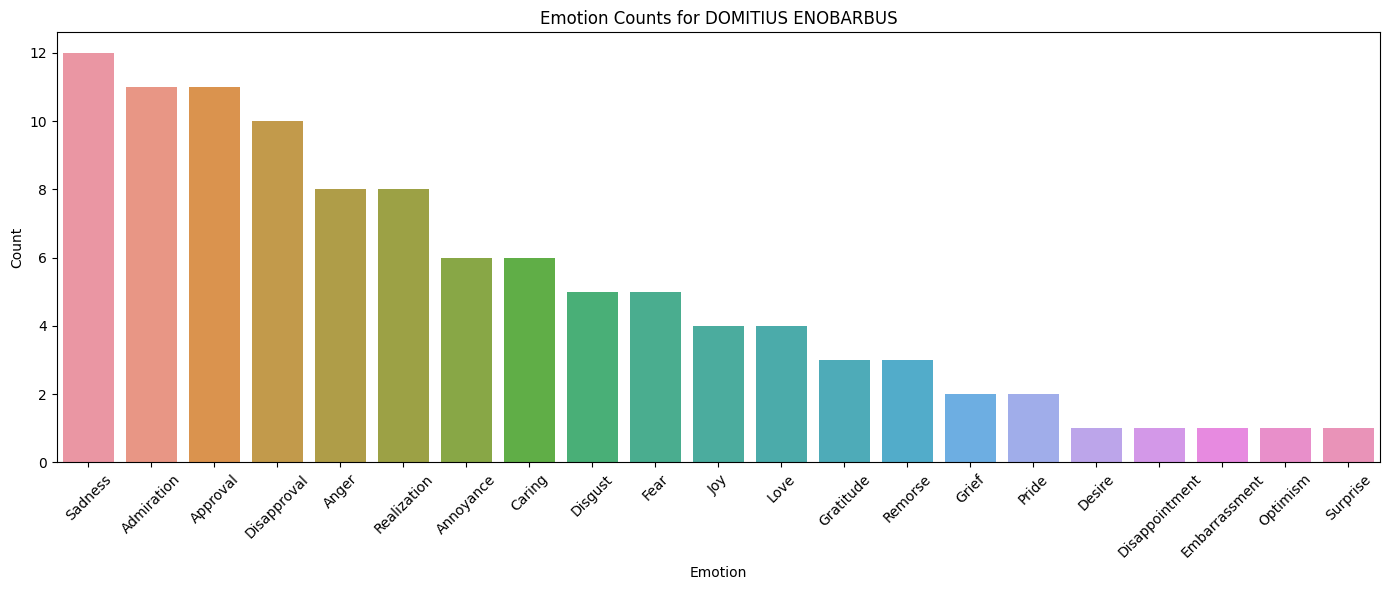

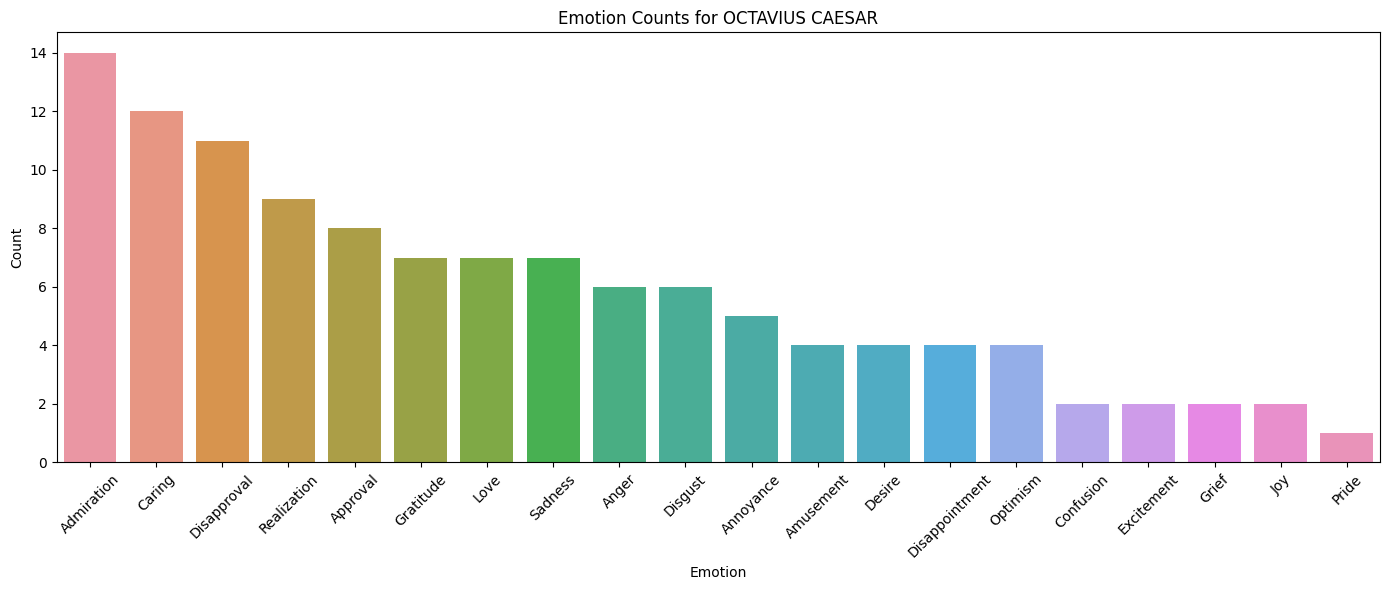

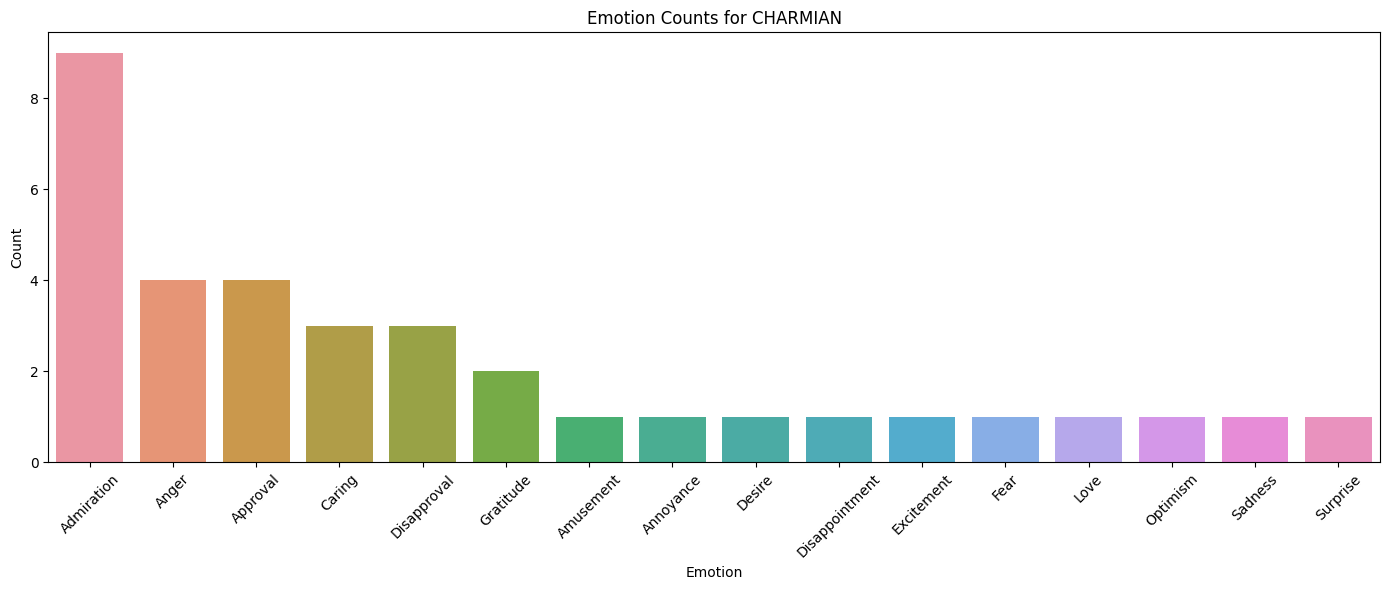

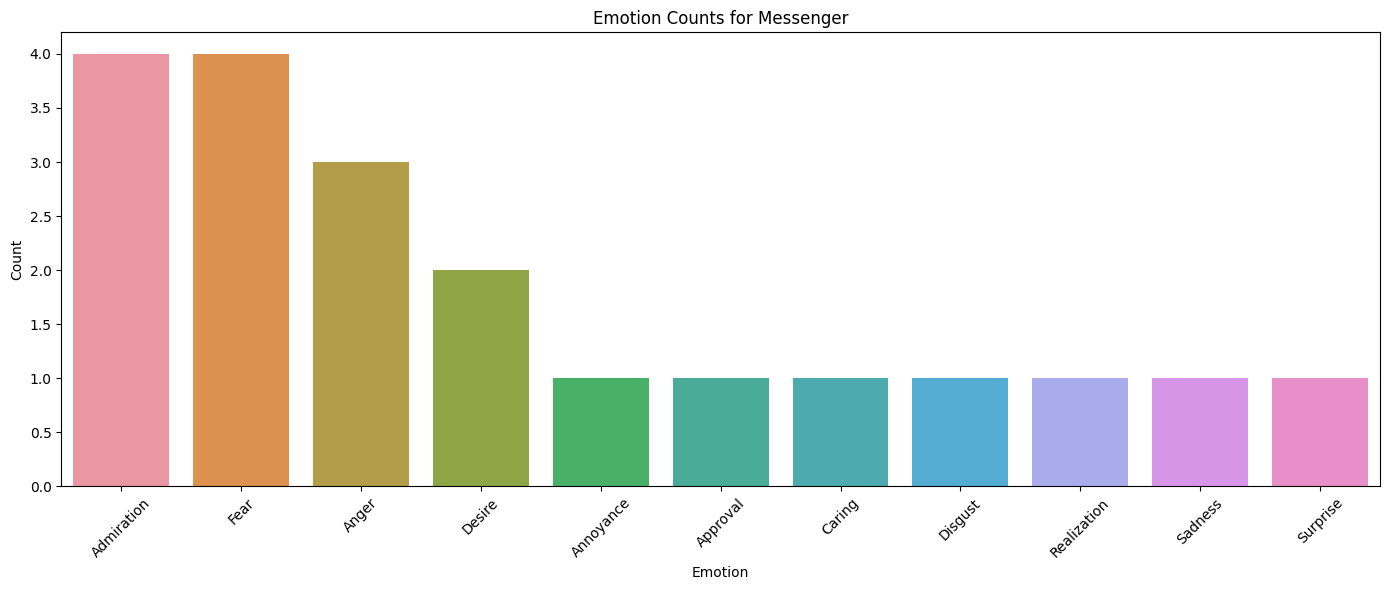

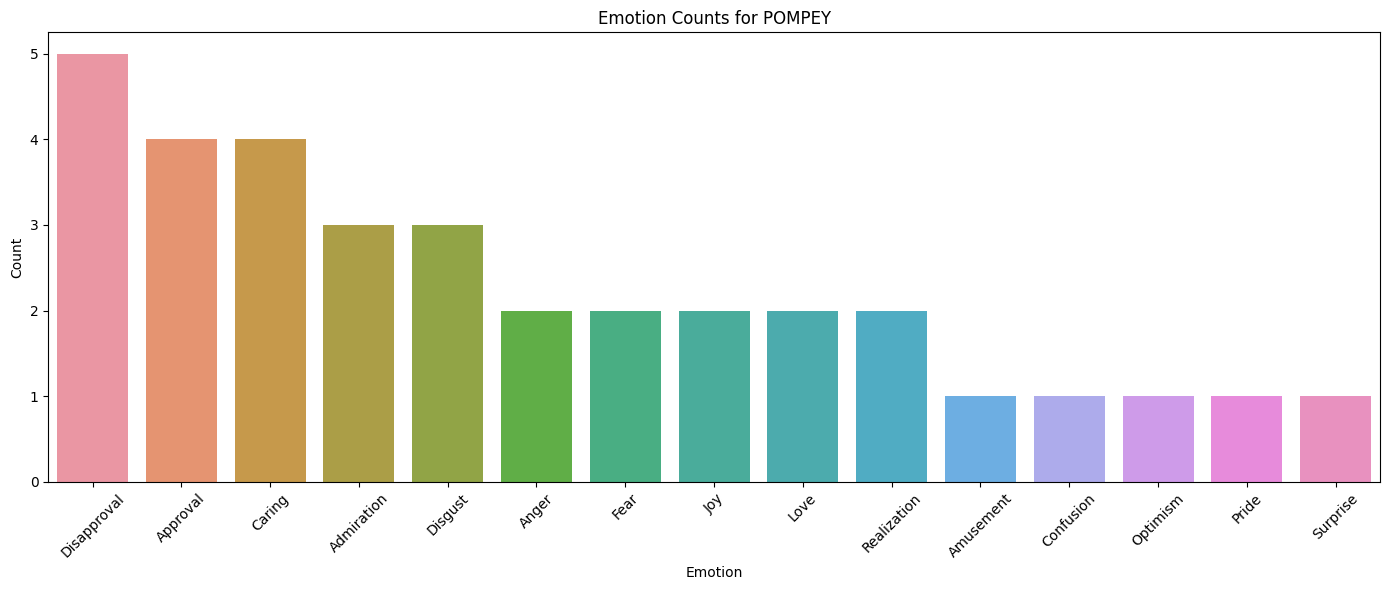

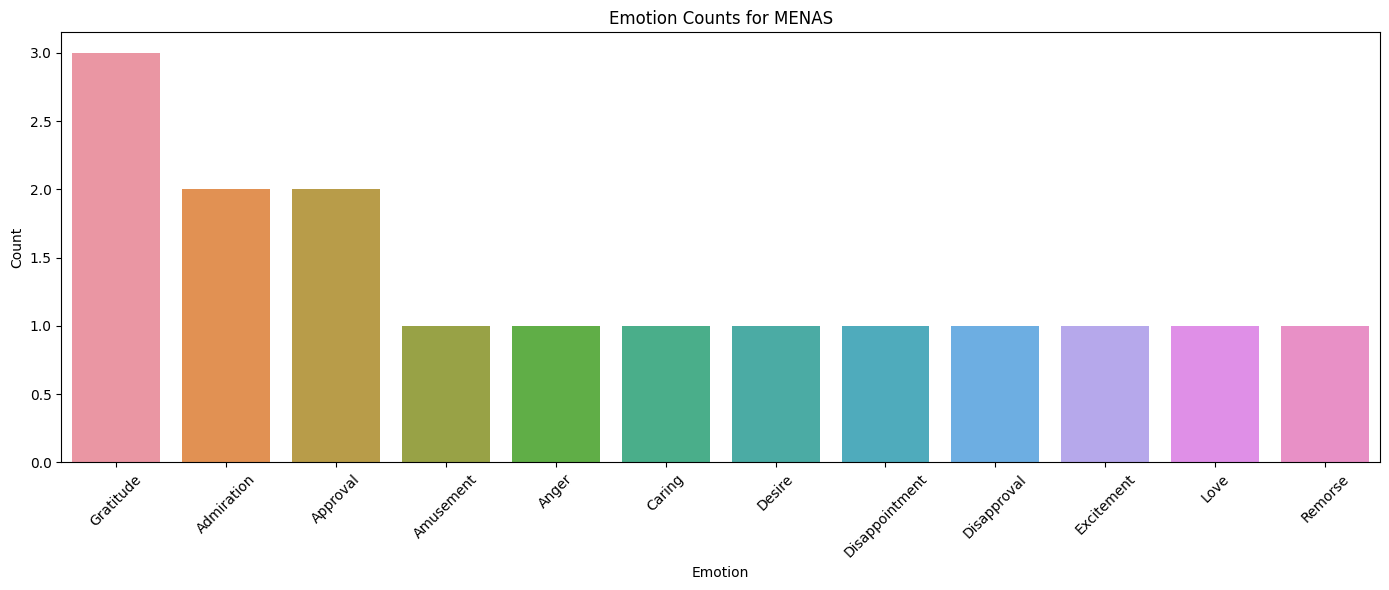

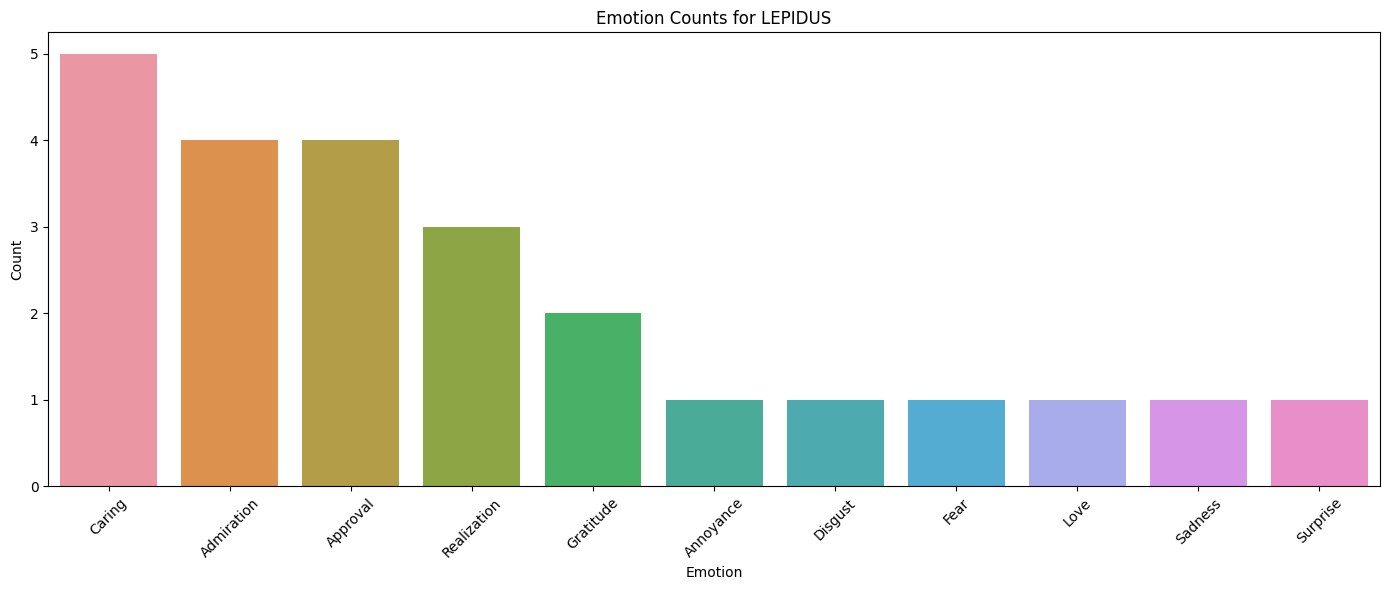

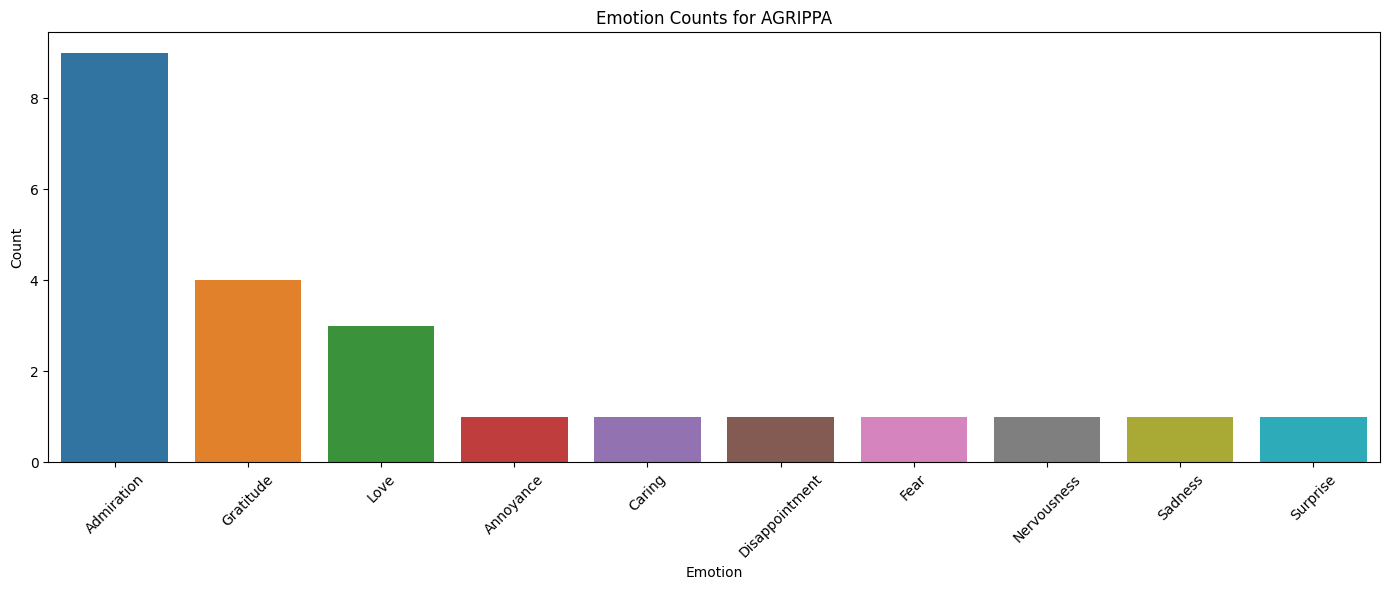

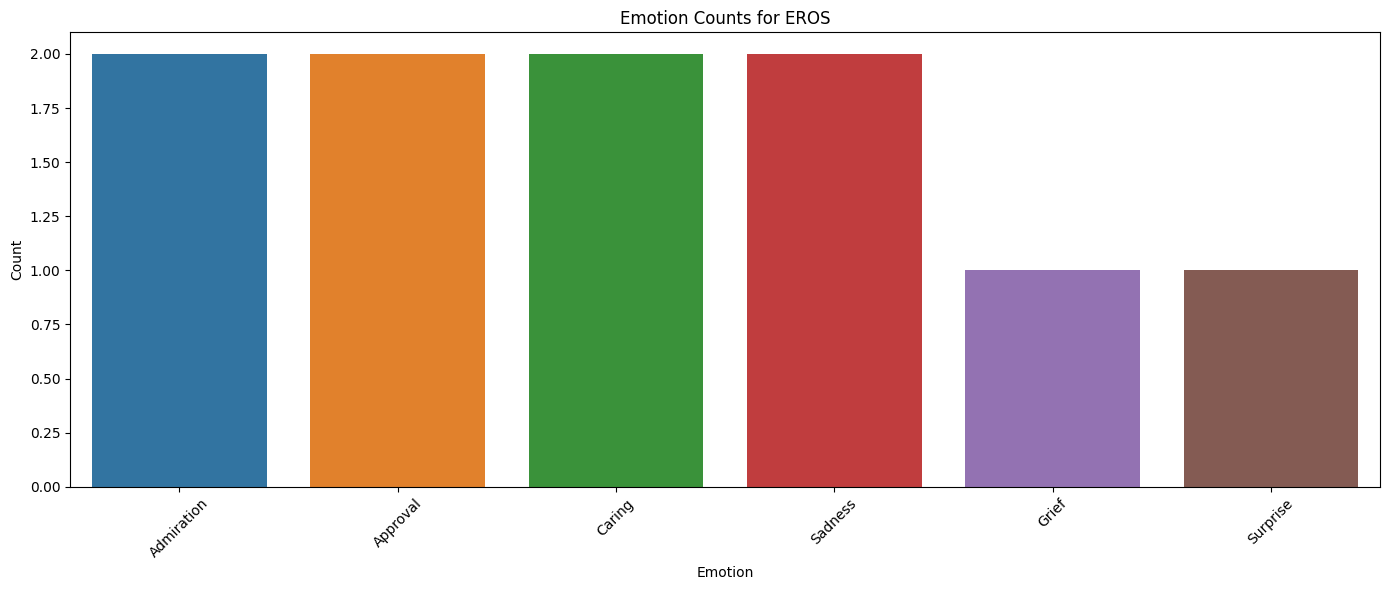

In [41]:
main_characters_df_2= main_characters_df[main_characters_df['First_Type_Emotion'] != 'Neutral']
main_characters_df = main_characters_df[(main_characters_df['Second_Type_Emotion'] != 'Neutral') & (main_characters_df['Second_Type_Emotion'] != 'Curiosity')]
emotion_counts = main_characters_df.groupby('Player')['Second_Type_Emotion'].value_counts()

# Creating separate plots, where each plot represents the emotions expressed by each player
for player in main_characters:
    player_emotion_counts = emotion_counts.loc[player]

    plt.figure(figsize=(14, 6))
    sns.barplot(x=player_emotion_counts.index, y=player_emotion_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title(f'Emotion Counts for {player}')
    plt.tight_layout()

    plt.show()

## Representing The Emotional Evolution Of The Main Characters Throughout The Play

- The aim of this section is to view the dominant emotion of each player throughout the play, meaning to view the emotional evolution of each player in each act. This would help us understand, or at least give us an idea of the dominant emotional stage the player is experiencing in each act.

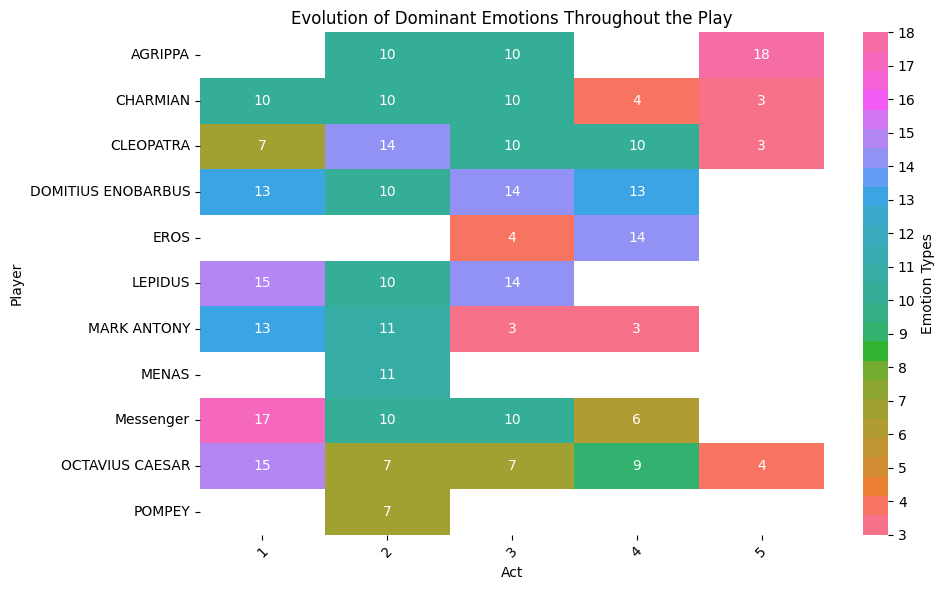

{'Love': 1, 'Grief': 2, 'Anger': 3, 'Caring': 4, 'Embarrassment': 5, 'Annoyance': 6, 'Disapproval': 7, 'Confusion': 8, 'Amusement': 9, 'Admiration': 10, 'Gratitude': 11, 'Optimism': 12, 'Sadness': 13, 'Approval': 14, 'Realization': 15, 'Disgust': 16, 'Fear': 17, 'Surprise': 18, 'Joy': 19, 'Remorse': 20, 'Desire': 21, 'Pride': 22, 'Disappointment': 23, 'Excitement': 24, 'Nervousness': 25, 'Relief': 26}


In [42]:
# Calculating the dominant emotion in each act for each player
dominant_emotions = main_characters_df.groupby(['Player', 'Act'])['Second_Type_Emotion'].apply(lambda x: x.value_counts().idxmax())
unique_emotions = main_characters_df['Second_Type_Emotion'].unique()

# Creating a mapping of emotions to numeric values
emotion_mapping = {emotion: i + 1 for i, emotion in enumerate(unique_emotions)}

# Creating a pivot table to prepare data for the heatmap we're planning to plot
heatmap_data = dominant_emotions.reset_index().pivot(index='Player', columns='Act', values='Second_Type_Emotion')

# Converting emotion_mapping to a dictionary with numeric values --> so that we can understand the numbering in the heatmap output
emotion_dict_numeric = {k: v for k, v in emotion_mapping.items()}

# Mapping the numeric emotion values to the pivot table
heatmap_data_numeric = heatmap_data.replace(emotion_dict_numeric)

# Creating a colormap to map emotion numbers to colors
cmap = sns.color_palette("husl", len(unique_emotions))

# Creating a heatmap to showcase the evolution of emotions throughout the play
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_numeric, cmap=cmap, annot=True, xticklabels=True, cbar_kws={'ticks': list(emotion_mapping.values()), 'label': 'Emotion Types'})
plt.xticks(rotation=45)
plt.xlabel('Act')
plt.ylabel('Player')
plt.title('Evolution of Dominant Emotions Throughout the Play')
plt.tight_layout()

plt.show()
print(emotion_dict_numeric)

## Comparing With The Initial Emotion Detection Technique Results

- Aim of this section is to do a comparison between the hugging face model and the non hugging face model.

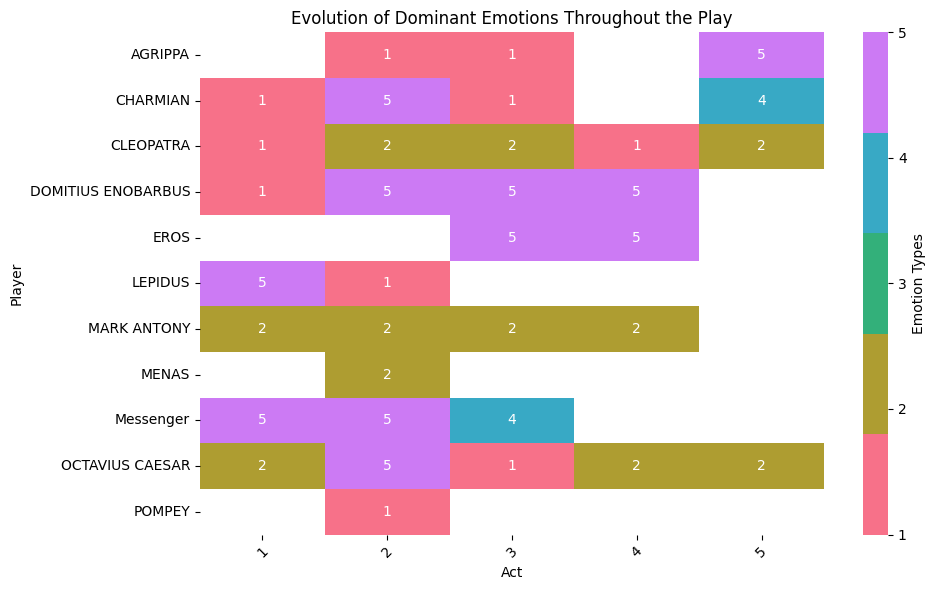

{'Happy': 1, 'Fear': 2, 'Angry': 3, 'Surprise': 4, 'Sad': 5}


In [43]:
dominant_emotions = main_characters_df_2.groupby(['Player', 'Act'])['First_Type_Emotion'].apply(lambda x: x.value_counts().idxmax())
unique_emotions = main_characters_df_2['First_Type_Emotion'].unique()

emotion_mapping = {emotion: i + 1 for i, emotion in enumerate(unique_emotions)}

heatmap_data = dominant_emotions.reset_index().pivot(index='Player', columns='Act', values='First_Type_Emotion')

emotion_dict_numeric = {k: v for k, v in emotion_mapping.items()}

heatmap_data_numeric = heatmap_data.replace(emotion_dict_numeric)

cmap = sns.color_palette("husl", len(unique_emotions))

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_numeric, cmap=cmap, annot=True, xticklabels=True, cbar_kws={'ticks': list(emotion_mapping.values()), 'label': 'Emotion Types'})
plt.xticks(rotation=45)
plt.xlabel('Act')
plt.ylabel('Player')
plt.title('Evolution of Dominant Emotions Throughout the Play')
plt.tight_layout()

plt.show()
print(emotion_dict_numeric)

- We notice that the second type of emotion detection using Hugging Face Hub's EmoRoBERTa gives a more reliable presentation of the emotional evolution of the characters throughout the play, especially Cleopatra

## Representing The Emotional Evolution Of Main Characters Throughout Each Act

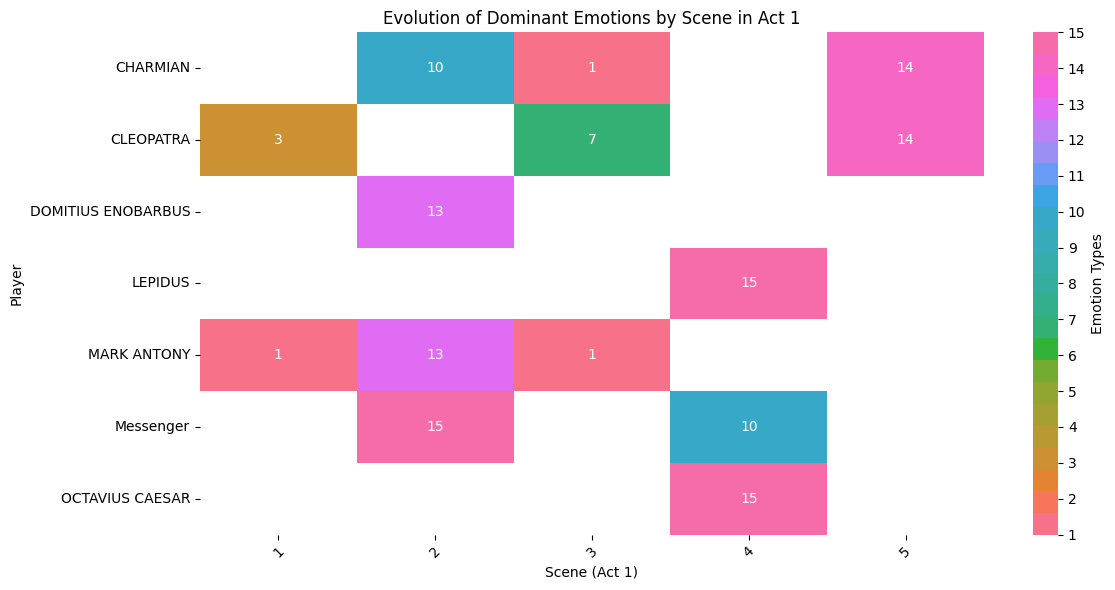

{'Love': 1, 'Grief': 2, 'Anger': 3, 'Caring': 4, 'Embarrassment': 5, 'Annoyance': 6, 'Disapproval': 7, 'Confusion': 8, 'Amusement': 9, 'Admiration': 10, 'Gratitude': 11, 'Optimism': 12, 'Sadness': 13, 'Approval': 14, 'Realization': 15, 'Disgust': 16, 'Fear': 17, 'Surprise': 18, 'Joy': 19, 'Remorse': 20, 'Desire': 21, 'Pride': 22, 'Disappointment': 23}


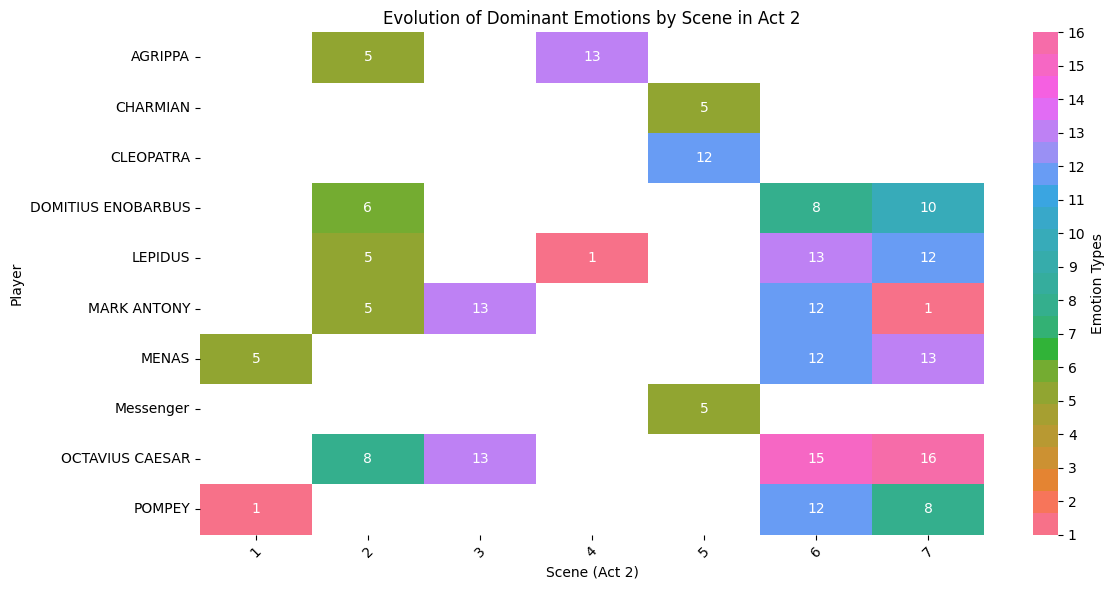

{'Caring': 1, 'Anger': 2, 'Love': 3, 'Optimism': 4, 'Admiration': 5, 'Realization': 6, 'Disappointment': 7, 'Disapproval': 8, 'Amusement': 9, 'Fear': 10, 'Confusion': 11, 'Approval': 12, 'Gratitude': 13, 'Excitement': 14, 'Sadness': 15, 'Disgust': 16, 'Pride': 17, 'Annoyance': 18, 'Desire': 19, 'Grief': 20, 'Joy': 21, 'Surprise': 22, 'Remorse': 23}


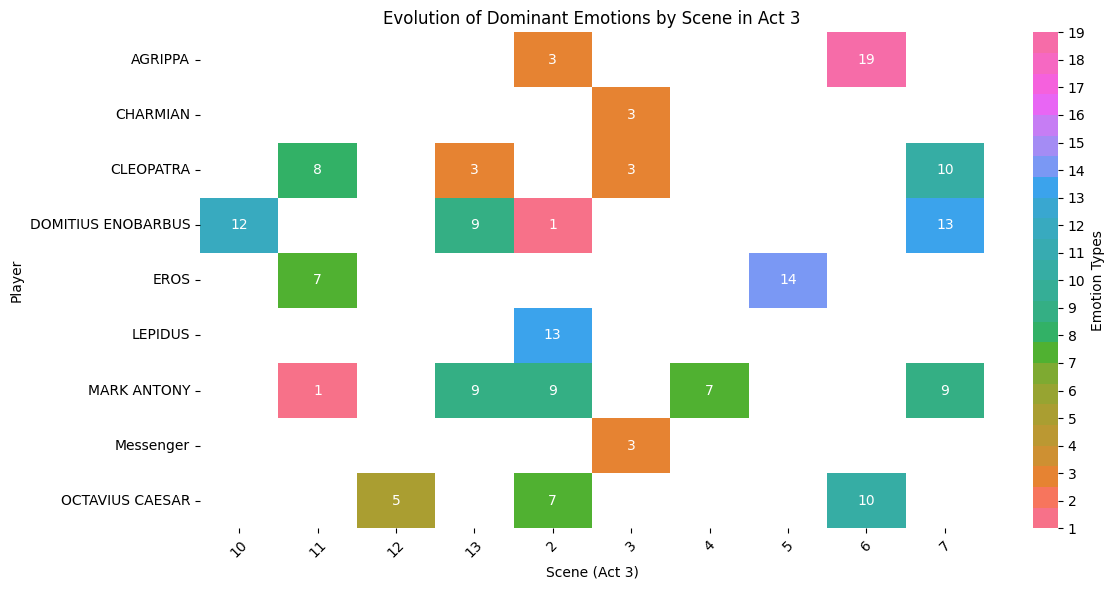

{'Sadness': 1, 'Fear': 2, 'Admiration': 3, 'Love': 4, 'Annoyance': 5, 'Disappointment': 6, 'Caring': 7, 'Gratitude': 8, 'Anger': 9, 'Disapproval': 10, 'Joy': 11, 'Disgust': 12, 'Approval': 13, 'Surprise': 14, 'Confusion': 15, 'Desire': 16, 'Remorse': 17, 'Realization': 18, 'Nervousness': 19, 'Excitement': 20, 'Optimism': 21, 'Embarrassment': 22, 'Grief': 23, 'Amusement': 24}


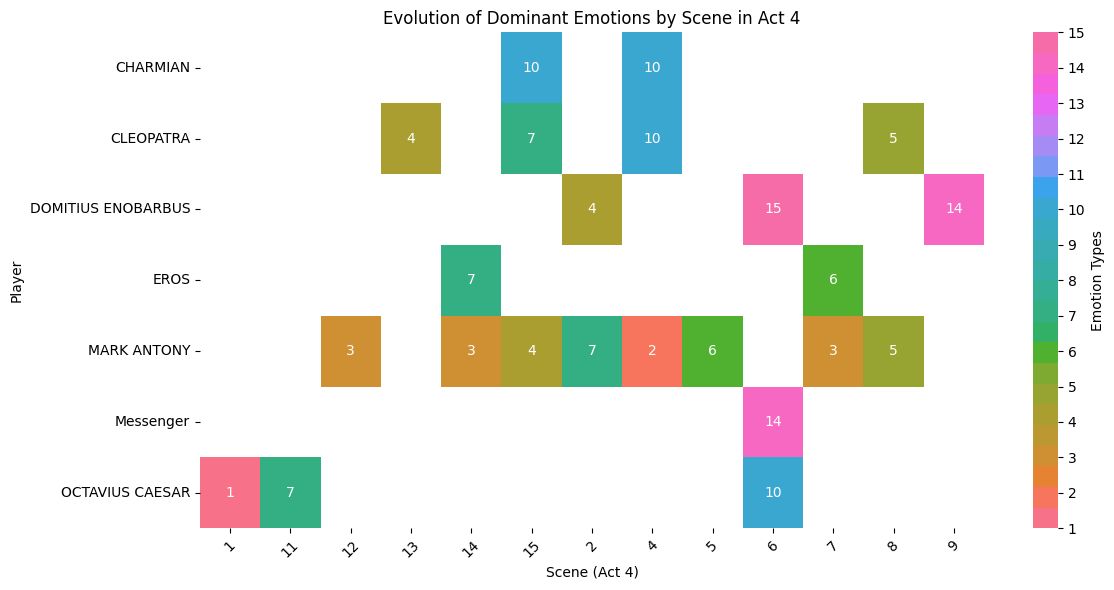

{'Amusement': 1, 'Disapproval': 2, 'Anger': 3, 'Sadness': 4, 'Gratitude': 5, 'Approval': 6, 'Admiration': 7, 'Desire': 8, 'Embarrassment': 9, 'Caring': 10, 'Optimism': 11, 'Excitement': 12, 'Love': 13, 'Annoyance': 14, 'Joy': 15, 'Remorse': 16, 'Realization': 17, 'Surprise': 18, 'Disgust': 19, 'Pride': 20, 'Grief': 21, 'Fear': 22, 'Disappointment': 23, 'Relief': 24}


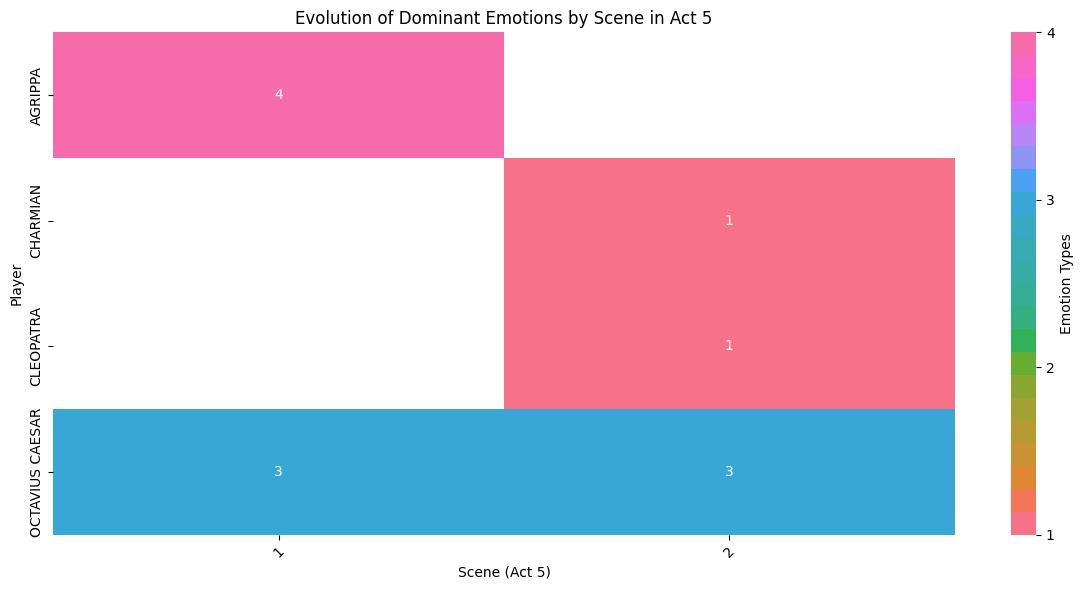

{'Anger': 1, 'Love': 2, 'Caring': 3, 'Surprise': 4, 'Sadness': 5, 'Admiration': 6, 'Gratitude': 7, 'Disgust': 8, 'Realization': 9, 'Annoyance': 10, 'Optimism': 11, 'Disapproval': 12, 'Desire': 13, 'Joy': 14, 'Approval': 15, 'Amusement': 16, 'Confusion': 17, 'Disappointment': 18, 'Embarrassment': 19, 'Fear': 20, 'Pride': 21, 'Grief': 22}


In [44]:
unique_acts = main_characters_df['Act'].unique()

# Loop through each act and create a heatmap
for act in unique_acts:
    # Filtering the DataFrame to include only scenes in the current act
    scenes_current_act = main_characters_df[main_characters_df['Act'] == act]

    # Calculating the dominant emotion in each scene for each character in the current act
    dominant_emotions = scenes_current_act.groupby(['Player', 'Act', 'Scene'])['Second_Type_Emotion'].apply(lambda x: x.value_counts().idxmax())

    # Creating a list of unique emotions for the current act
    unique_emotions = scenes_current_act['Second_Type_Emotion'].unique()

    # Creating a mapping of emotions to numeric values
    emotion_mapping = {emotion: i + 1 for i, emotion in enumerate(unique_emotions)}

    # Creating a pivot table to prepare data for the heatmap
    heatmap_data = dominant_emotions.reset_index().pivot(index='Player', columns='Scene', values='Second_Type_Emotion')

    # Converting emotion_mapping to a dictionary with numeric values
    emotion_dict_numeric = {k: v for k, v in emotion_mapping.items()}

    # Mapping the numeric emotion values to the pivot table
    heatmap_data_numeric = heatmap_data.replace(emotion_dict_numeric)

    # Creating a colormap to map emotion numbers to colors
    cmap = sns.color_palette("husl", len(unique_emotions))

    # Creating a heatmap to showcase the evolution of emotions throughout the play for the current act
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data_numeric, cmap=cmap, annot=True, xticklabels=True, cbar_kws={'ticks': list(emotion_mapping.values()), 'label': 'Emotion Types'})
    plt.xticks(rotation=45)
    plt.xlabel(f'Scene (Act {act})')
    plt.ylabel('Player')
    plt.title(f'Evolution of Dominant Emotions by Scene in Act {act}')
    plt.tight_layout()

    plt.show()
    print(emotion_dict_numeric)

## Two Approaches To Represent Characters' Interactions

### Using Social Network Analysis To Represent The Interaction Between The Main Characters & The Main Emotion Each Character Expresses Towards The Other

- The aim of creating this network is to visualize two things:

    1) The main emotion expressed by a character when another character is present. For example the main emotion expressed by Cleopatara when Mark Antony is present. In that case we would have an outgoing edge from Cleopatra to Mark Antony and the edge will contain the main emotion expressed as attribute.
    
    2) The interaction of a character whilst another character is present, this should mainly show the main interactions between characters.

In [45]:
main_characters_df.head()

,Play,Player,PlayerLine,Act,Scene,Line,StartOfSequence,First_Type_Emotion,Second_Type_Emotion
2,Antony and Cleopatra,CLEOPATRA,I'll set a bourn how far to be beloved.,1,1,17,True,Fear,Love
4,Antony and Cleopatra,MARK ANTONY,Grates me: the sum.,1,1,20,True,Angry,Grief
10,Antony and Cleopatra,CLEOPATRA,"Perform 't, or else we damn thee.'",1,1,26,False,Neutral,Anger
11,Antony and Cleopatra,MARK ANTONY,"How, my love!",1,1,27,True,Happy,Love
13,Antony and Cleopatra,CLEOPATRA,"You must not stay here longer, your dismission",1,1,29,False,Angry,Caring


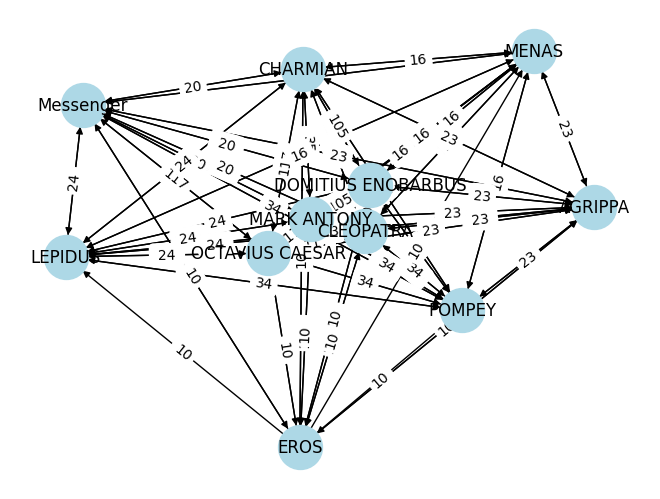

In [46]:
G = nx.DiGraph()

# Creating a defaultdict to store the most expressed emotion for each actor pair
most_expressed_emotion = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# Iterate through the DataFrame and populate the graph and emotion dictionary
for _, row in main_characters_df.iterrows():
    actor = row["Player"]
    scene = row["Scene"]
    act = row["Act"]
    emotion = row["Second_Type_Emotion"]

    G.add_node(actor)  # Add character node

    # Updating emotion count for the actor pair in the dictionary
    for prev_actor in G.nodes():
        if prev_actor != actor:
            most_expressed_emotion[actor][prev_actor][emotion] += 1
            if (actor, prev_actor) in G.edges():
                G.edges[actor, prev_actor]["weight"] += 1
            else:
                G.add_edge(actor, prev_actor, weight=1)

# Updating the emotion attribute of each edge in the graph
for actor, adj_dict in most_expressed_emotion.items():
    for prev_actor, emotion_count in adj_dict.items():
        most_common_emotion = max(emotion_count, key=emotion_count.get)
        G.edges[actor, prev_actor]["emotion"] = most_common_emotion

# Removing self-loops
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G)  # this is to store the positioning of nodes
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [47]:
nx.write_gexf(G = G, path = "Characters_Interaction_Graph.gexf")

### Considering Only Scenes Where There Are Only 2 Characters

- This might not be an optimal approach to implement due to the lack of scenes between only 2 players, but still it can be used to show the various emotions two players express towards one another.

In [48]:
filtered_lines = []

# Groupping lines by Act and Scene
grouped = main_characters_df.groupby(["Act", "Scene"])

for (act, scene), group in grouped:
    unique_players = group["Player"].unique()
    if len(unique_players) > 2:
        continue  # Skipping this group if there are more than 2 unique players

    for _, row in group.iterrows():
        # Finding the other player in the same act, scene, and emotion
        other_players = group[
            (group["Player"] != row["Player"]) &
            (group["Second_Type_Emotion"] == row["Second_Type_Emotion"])
        ]["Player"].unique()

        # Including only up to 2 other players in the "Other_Players" column
        other_players = other_players[:2]

        # Creating a comma-separated string of other players, excluding empty values
        other_players_str = ", ".join(player for player in other_players if player)

        # Adding the row to the filtered_lines list if other_players_str is not empty
        if other_players_str:
            filtered_lines.append({
                "Player": row["Player"],
                "Other_Player": other_players_str,
                "Act": act,
                "Scene": scene,
                "Line": row["Line"],
                "Second_Type_Emotion": row["Second_Type_Emotion"]
            })

filtered_df = pd.DataFrame(filtered_lines)
filtered_df.head(10)

,Player,Other_Player,Act,Scene,Line,Second_Type_Emotion
0,CLEOPATRA,MARK ANTONY,1,1,17,Love
1,MARK ANTONY,CLEOPATRA,1,1,27,Love
2,MARK ANTONY,CLEOPATRA,1,1,38,Annoyance
3,MARK ANTONY,CLEOPATRA,1,1,41,Disapproval
4,MARK ANTONY,CLEOPATRA,1,1,43,Annoyance
5,CLEOPATRA,MARK ANTONY,1,1,44,Disapproval
6,CLEOPATRA,MARK ANTONY,1,1,46,Annoyance
7,MARK ANTONY,CLEOPATRA,1,1,49,Love
8,CLEOPATRA,CHARMIAN,1,5,4,Approval
9,CLEOPATRA,CHARMIAN,1,5,6,Approval


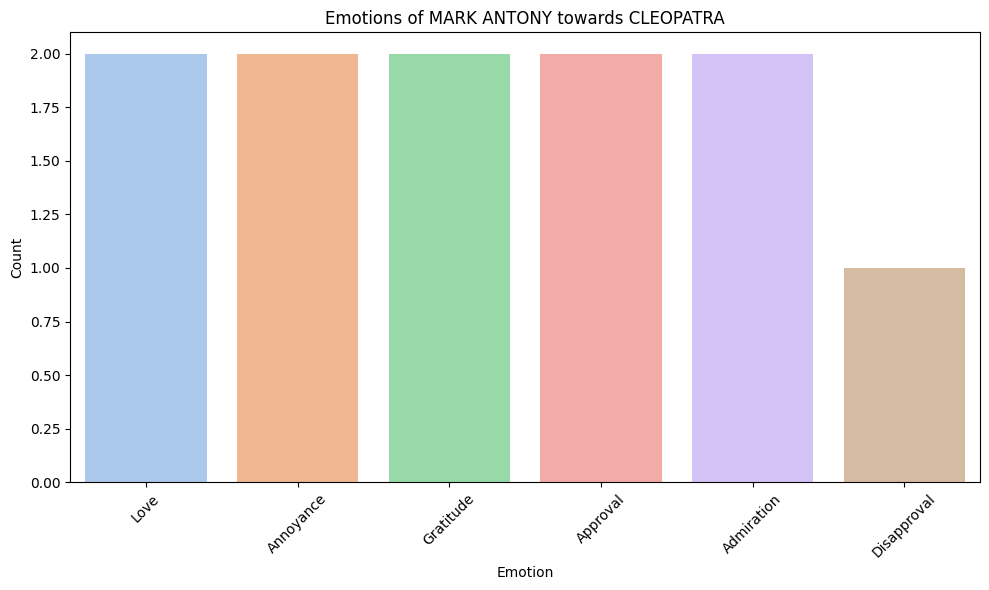

In [49]:
mark_to_cleo_df = filtered_df[
    (filtered_df["Player"] == "MARK ANTONY") &
    (filtered_df["Other_Player"].str.contains("CLEOPATRA"))
]

emotion_counts = mark_to_cleo_df["Second_Type_Emotion"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="pastel")
plt.title("Emotions of MARK ANTONY towards CLEOPATRA")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()